# Open economy HANK

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
import sequence_jacobian as sj

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

In [3]:
from household import hh, calibration
hh = hh.remap({'r': 'rp'})
calibration['rp'] = calibration['r']

In [4]:
# Compute steady state
ss = hh.steady_state(calibration)

In [5]:
# time horizon used here
T = 400

Add to the calibration dict

In [6]:
calibration |= {
               'alpha': 0.4,  # home's foreign good preference, (1 - alpha) is the home's home bias
               'alphastar': 0.4,  # foreign's home good preference, (1 - alpha_star) is the foreign's home bias
               'eta': 1.01,  # elasticity of substitution between goods
               'gamma': 0.394,  # elasticity of foreign demand
               'markup_ss': 1/ss['Z'],  # steady state markup
               'Y': 1,  # Output
               'nfa': 0,  # net foreign assets
               'rstar': ss['rp'],  # foreign interest rate
               'Cstar': 1,  # foreign consumption
               'Q': 1}  # Foreign demand

## Set up all the blocks

We'll need a few more `SimpleBlock`s.

First up, a block that splits up total domestic consumption `C` into home and foreign consumption, `cH` and `cF`.

In [7]:
@sj.simple
def dom_demand(C, PF_P, PH_P, eta, alpha):
    cH = (1 - alpha) * PH_P ** (-eta) * C  # PH_P is the real (in domestic cons. good units) price of the home good consumed domestically
    cF = alpha * PF_P ** (-eta) * C  # PF_P is the real (in domestic cons. good units) price of the foreign good consumed domestically
    return cH, cF

Next, foreign demand for home goods.

In [8]:
@sj.simple
def for_demand(PHstar, alphastar, gamma, Cstar):
    cHstar = alphastar * PHstar ** (-gamma) * Cstar  # PHstar is the real (in domestic cons. good units) price of the home good consumed abroad
    return cHstar

Next, a UIP block that solves for the real exchange rate `Q` as function of the interest rates. It also computes the relative prices of home and foreign goods.

In [9]:
@sj.solved(unknowns={'Q': (0.01, 300.)}, targets=['uip'])
def UIP(Q, r, rstar, eta, alpha, gamma):
    # recursive equation for UIP to pin down RER Q
    uip = 1 + r - (1 + rstar) * Q(1) / Q
    
    # price of H goods abroad in terms of Q
    PHstar = ((Q ** (eta - 1) - alpha) / (1 - alpha)) ** (1 / (1 - eta))
    
    # price of H goods at home in terms of Q
    PH_P = ((1 - alpha * Q ** (1 - eta)) / (1 - alpha)) ** (1 / (1 - eta))
    
    # price of F goods at home in terms of Q
    PF_P = Q  # LOOP
    
    # let's also compute chi, as an important object in the theory
    chi = eta * (1-alpha) + gamma
    return uip, PHstar, PH_P, PF_P, chi

Next, a block that computes real labor income `Z`, dividends and stock valuations.

In [10]:
@sj.solved(unknowns={'J': (0.001, 100.)}, targets=['valuation_cond'])
def income(Y, PH_P, J, r, markup_ss):
    # real labor income
    Z = 1 / markup_ss * PH_P * Y
    
    # real dividend
    div = (1 - 1 / markup_ss) * PH_P * Y   
    
    # nominal PPP adjusted GDP
    gdp = PH_P * Y
    
    # valuation condition to price the asset
    valuation_cond = div + J(1) / (1 + r) - J  # J = beginning of period valuation
    j = J(1) / (1 + r)  # j = end of period valuation
    
    # ex post interest rate incl revaluation
    rp = J / j(-1) - 1
    
    # get assets to labor income ratio (will need this to calibrate to the household block)
    j_to_Z = j / Z
    return j, valuation_cond, gdp, div, Z, rp, j_to_Z

Next, a block that evaluates the balance of payments and computes the NFA.

In [11]:
@sj.solved(unknowns={'nfa': (-100., 100.)}, targets=['nfa_cond'])
def bop(nfa, PH_P, cHstar, PF_P, cF, r):
    NX = PH_P * cHstar - PF_P * cF  # PH_P * Y - PF_P * cF - PH_P * cH
    nfa_cond = NX + (1 + r(-1)) * nfa(-1) - nfa
    return NX, nfa_cond

Finally, a market clearing block.

In [12]:
@sj.simple
def mkt_clearing(Y, cH, cHstar, A, nfa, j):
    goods_mkt = cH + cHstar - Y
    asset_mkt = A - nfa - j
    return goods_mkt, asset_mkt

With that, we are ready to define the model.

In [13]:
ha = sj.create_model([UIP, income, hh, dom_demand, for_demand, bop,  mkt_clearing], name="HA Model")

Let's also set up the RA model.

In [14]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, rp):
    euler = (beta * (1 + rp(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + rp) * A(-1) + Z - C - A
    return euler, budget_constraint

ra = sj.create_model([UIP, income, hh_ra, dom_demand, for_demand, bop,  mkt_clearing], name="RA model")

## Calibrate the two models

### Heterogeneous agent model

We want to reuse the same steady state for the household from before. 

First, we need to find the right markups. We want to choose markups such that the asset to labor income ratio in the household block is the same as in the steady state.

In [15]:
# get the asset to labor income ratio from the household block
A_to_Z = ss['A'] / ss['Z']

# find the markup_ss that j / Z is the same
income_ss = income.solve_steady_state({**ss, 'PH_P': 1, 'r': ss['rp'], 'Y': 1}, unknowns={'markup_ss': (1.01, 1.5)},targets={'j_to_Z': A_to_Z})

calibration['markup_ss'] = income_ss['markup_ss'] 

Now, we can run the steady state. Note: we need to undo the UIP `SolvedBlock` to avoid erros here because you can't solve the UIP equation in the steady state for `Q` ! (`Q` drops out of the equation!) We do the same for `bop` but there it's not strictly necessary. Just for numerical purposes.

In [16]:
ss_ha = ha.steady_state(calibration, dissolve=['UIP', 'bop'])

We should be pretty close for market clearing conditions.

In [17]:
ss_ha['goods_mkt'], ss_ha['asset_mkt']

(6.9166073428661434e-06, 0.0022344775077840495)

Let's make sure we get it to Matt standards.

In [18]:
ss_ha = ha.solve_steady_state(calibration, unknowns={'beta_hi': (ss_ha['beta_hi']-1e-5, ss_ha['beta_hi'])}, targets=['asset_mkt'], dissolve=['UIP', 'bop'])

Check again:

In [19]:
ss_ha['goods_mkt'], ss_ha['asset_mkt']

(2.2426706847156197e-07, -3.554703198460629e-10)

Perfect, this looks great. Matt will be happy.

Let's make sure the rest of the steady state makes sense.

In [20]:
# Make sure prices are 1 in steady state
for var in ['PH_P', 'PF_P', 'PHstar', 'Q']:
    assert np.isclose(ss_ha[var], 1), f"Price {var} is not 1 in steady state, it is {ss_ha[var]}"
    
# Make sure the following objects are close to zero
for var in ['valuation_cond', 'nfa_cond', 'goods_mkt', 'asset_mkt', 'nfa', 'NX']:
    assert np.isclose(ss_ha[var], 0, atol=1e-6), f"Condition {var} is not zero in steady state, it is {ss_ha[var]}"

### Representative agent model

Let's move on to the representative agent model. First up, we need to explicitly set `beta` for the model. We can then use that to evaluate the RA steady state.

In [21]:
beta = 1 / (1 + calibration['rp'])
ss_ra = ra.steady_state({**ss_ha, 'beta': beta}, dissolve=['UIP', 'bop', 'hh_ra'])

Run the same checks.

In [22]:
# Make sure prices are 1 in steady state
for var in ['PH_P', 'PF_P', 'PHstar', 'Q']:
    assert np.isclose(ss_ra[var], 1), f"Price {var} is not 1 in steady state, it is {ss_ha[var]}"
    
# Make sure the following objects are close to zero
for var in ['valuation_cond', 'nfa_cond', 'goods_mkt', 'asset_mkt', 'nfa', 'NX']:
    assert np.isclose(ss_ra[var], 0, atol=1e-6), f"Condition {var} is not zero in steady state, it is {ss_ha[var]}"

Looks great!

## Foreign interest rate shocks

We begin by plotting output and consumption in response to a foreign interest rate shock.

In [23]:
T = 300

# define shock
drstar = 0.25 * 0.8 ** np.arange(T)  # a transitory foreign interest rate shock [normalization to get depreciation of 1%]
shock = {'rstar': drstar}

# set unknowns and targets
unknowns_td = ['Y']
targets_td = ['goods_mkt']

Vary elasticities and plot output and consumption responses.

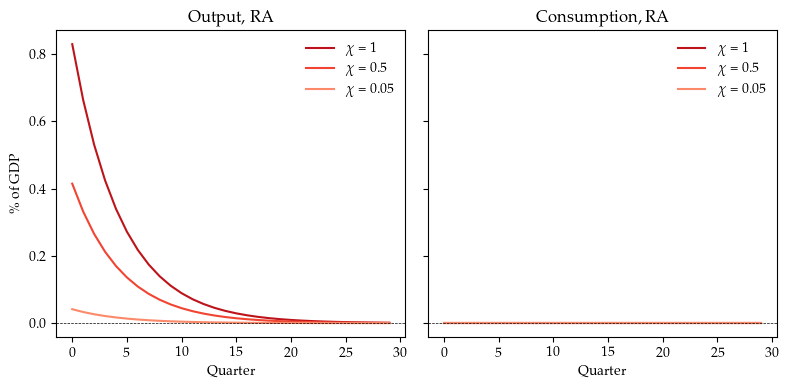

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# get three shades of red
colors_ra = plt.cm.Reds(np.linspace(0.4, 0.8, 3)[::-1])

for i, chi in enumerate([1, 0.5, 0.05]):
    # scale down eta and gamma so that (1-alpha) * eta + gamma = chi
    old_chi = ss_ra['chi']
    ss_ = ss_ra.copy()
    ss_['eta'] = ss_ra['eta'] * chi / old_chi
    ss_['gamma'] = ss_ra['gamma'] * chi / old_chi
    irfs_ra = ra.solve_impulse_linear(ss_, unknowns_td, targets_td, shock)
    
    # Plot output (Y) on the left panel
    axes[0].plot(irfs_ra['Y'][:30], label=f'$\chi$ = {chi}', color=colors_ra[i])
    
    # Plot consumption (C) on the right panel
    axes[1].plot(irfs_ra['C'][:30], label=f'$\chi$ = {chi}', color=colors_ra[i])

# Customize left panel (Output)
axes[0].axhline(0, color='k', lw=0.5, ls='--')
axes[0].set_xlabel('Quarter')
axes[0].set_title('Output, RA')
axes[0].set_ylabel('\% of GDP')
axes[0].legend(frameon=False)

# Customize right panel (Consumption)
axes[1].axhline(0, color='k', lw=0.5, ls='--')
axes[1].set_xlabel('Quarter')
axes[1].set_title('Consumption, RA')
axes[1].legend(frameon=False)

plt.tight_layout()
plt.savefig('figures/lecture8_output_ra_y_and_c.pdf', bbox_inches='tight', transparent=True)

Next, we make the same style plot, except that we show output of the RA model left (as before) but the output of the HA model on the right.

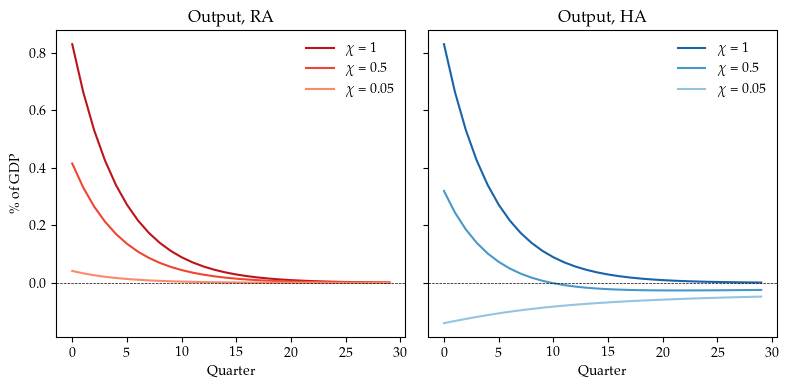

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# get three shades of red
colors_ra = plt.cm.Reds(np.linspace(0.4, 0.8, 3)[::-1])
colors_ha = plt.cm.Blues(np.linspace(0.4, 0.8, 3)[::-1])

for i, chi in enumerate([1, 0.5, 0.05]):
    # scale down eta and gamma so that (1-alpha) * eta + gamma = chi
    old_chi = ss_ra['chi']
    ss_ra_ = ss_ra.copy()
    ss_ra_['eta'] = ss_ra['eta'] * chi / old_chi
    ss_ra_['gamma'] = ss_ra['gamma'] * chi / old_chi
    irfs_ra = ra.solve_impulse_linear(ss_ra_, unknowns_td, targets_td, shock)
    
    # solve HA model with the same shock
    ss_ha_ = ss_ha.copy()
    ss_ha_['eta'] = ss_ra_['eta']
    ss_ha_['gamma'] = ss_ra_['gamma']
    irfs_ha = ha.solve_impulse_linear(ss_ha_, unknowns_td, targets_td, shock)
    
    # Plot output (Y) on the left panel
    axes[0].plot(irfs_ra['Y'][:30], label=f'$\chi$ = {chi}', color=colors_ra[i])
    
    # Plot consumption (C) on the right panel
    axes[1].plot(irfs_ha['Y'][:30], label=f'$\chi$ = {chi}', color=colors_ha[i])

# Customize left panel (Output RA)
axes[0].axhline(0, color='k', lw=0.5, ls='--')
axes[0].set_xlabel('Quarter')
axes[0].set_title('Output, RA')
axes[0].set_ylabel('\% of GDP')
axes[0].legend(frameon=False)

# Customize right panel (Output HA)
axes[1].axhline(0, color='k', lw=0.5, ls='--')
axes[1].set_xlabel('Quarter')
axes[1].set_title('Output, HA')
axes[1].legend(frameon=False)

plt.tight_layout()
plt.savefig('figures/lecture8_output_ra_ha.pdf', bbox_inches='tight', transparent=True)

## Monetary policy shocks

Take the same shock path, but feed it in as shock to `r`.

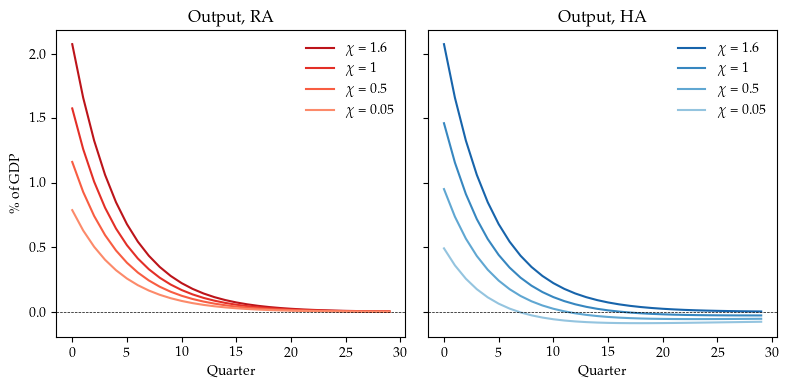

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Define a monetary policy shock
dr = - 0.25 * 0.8 ** np.arange(T)  # transitory monetary policy shock
shock = {'r': dr}

# Get three shades of blue for HA
colors_ra = plt.cm.Reds(np.linspace(0.4, 0.8, 4)[::-1])
colors_ha = plt.cm.Blues(np.linspace(0.4, 0.8, 4)[::-1])

for i, chi in enumerate([2-ss_ha['alpha'], 1, 0.5, 0.05]):
    # Scale down eta and gamma so that (1-alpha) * eta + gamma = chi
    old_chi = ss_ra['chi']
    ss_ra_ = ss_ra.copy()
    ss_ra_['eta'] = ss_ra['eta'] * chi / old_chi
    ss_ra_['gamma'] = ss_ra['gamma'] * chi / old_chi
    irfs_ra = ra.solve_impulse_linear(ss_ra_, unknowns_td, targets_td, shock)
    
    # Solve HA model with the same shock
    ss_ha_ = ss_ha.copy()
    ss_ha_['eta'] = ss_ra_['eta']
    ss_ha_['gamma'] = ss_ra_['gamma']
    irfs_ha = ha.solve_impulse_linear(ss_ha_, unknowns_td, targets_td, shock)
    
    # Plot output (Y RA) on the left panel
    axes[0].plot(irfs_ra['Y'][:30], label=f'$\chi$ = {chi}', color=colors_ra[i])
    
    # Plot consumption (Y HA) on the right panel
    axes[1].plot(irfs_ha['Y'][:30], label=f'$\chi$ = {chi}', color=colors_ha[i])

# Customize left panel (Output RA)
axes[0].axhline(0, color='k', lw=0.5, ls='--')
axes[0].set_xlabel('Quarter')
axes[0].set_title('Output, RA')
axes[0].set_ylabel('\% of GDP')
axes[0].legend(frameon=False)

# Customize right panel (Output HA)
axes[1].axhline(0, color='k', lw=0.5, ls='--')
axes[1].set_xlabel('Quarter')
axes[1].set_title('Output, HA')
axes[1].legend(frameon=False)

plt.tight_layout()
plt.savefig('figures/lecture8_monetary_shock_ra_ha.pdf', bbox_inches='tight', transparent=True)